In [1]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import tensorflow as tf
from tensorflow.keras import Model,Sequential, losses, optimizers, metrics, layers, initializers
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from scipy.stats import pearsonr
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,TensorBoard,LearningRateScheduler
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K
from tqdm import tqdm
from collections import Counter
import random
import os
from os import listdir
import math
import h5py
import itertools
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
year = 2020
dates = pd.date_range(start='04/09/{}'.format(year), end='24/09/{}'.format(year),freq='6d')
dates_str = [str(d).split(' ')[0] for d in dates]

features = np.array(['SAR_VV','SAR_VH','SAR_CROSS_RATIO','SAR_RATIO','InSAR_VV','InSAR_VH','InSAR_mixed','NDVI'])

In [3]:
dataset = h5py.File('cloud_gap_filling_data.h5', 'r')
X = np.array(dataset['X']).copy()
y = np.array(dataset['y']).copy()
masks = np.array(dataset['artificial_cloud_absense']).copy()
masks_ne = np.array(dataset['actual_cloud_absense']).copy()
masks_fused = np.array(dataset['training_weights']).copy()
pixel_id = np.array(dataset['pixel_id']).astype('str').copy()
parcel_id = np.array(dataset['parcel_id']).astype('str').copy()
regions = np.array(dataset['study_regions']).astype('str').copy()
ids_num_train = np.array(dataset['training_instances']).copy()
ids_num_val = np.array(dataset['validation_instances']).copy()
dataset.close()

In [4]:
X_train, X_val = X[ids_num_train], X[ids_num_val]
y_train, y_val = y[ids_num_train], y[ids_num_val]
masks_fused_train, masks_fused_val = masks_fused[ids_num_train], masks_fused[ids_num_val]
masks_train, masks_val = masks[ids_num_train], masks[ids_num_val]
masks_ne_train, masks_ne_val = masks_ne[ids_num_train], masks_ne[ids_num_val]
pixel_id_train, pixel_id_val = pixel_id[ids_num_train], pixel_id[ids_num_val]
parcel_id_train, parcel_id_val = parcel_id[ids_num_train], parcel_id[ids_num_val]
regions_train, regions_val = regions[ids_num_train], regions[ids_num_val]

In [5]:
X_new_train = []
X_new_val = []
for i in range(X.shape[2]):
    X_new_train.append(X_train[:,:,i].copy())
    X_new_val.append(X_val[:,:,i].copy())

In [6]:
def mse_custom(y_true, y_pred):

    error = tf.where(y_true > 0., y_true - y_pred, 0)

    return K.mean(K.square(error), axis=-1)


def mae_custom(y_true, y_pred):
    
    error = tf.where(y_true > 0., y_true - y_pred, 0)
    
    return K.mean(K.abs(error), axis=-1)

n_timesteps, n_features, n_outputs  = X.shape[1],X.shape[2],X.shape[1]


def add_cnn_block_1D(x_inp,filters,kernel_size=3,padding="same",strides=1):

    x = layers.Conv1D(filters,kernel_size,padding=padding, strides=strides,
                      kernel_initializer=initializers.glorot_normal())(x_inp)
    x = layers.Activation('relu')(x)

    return x


def attention_seq(query_value, scale):

    query, value = query_value
    score = tf.matmul(query, value, transpose_b=True) # (batch, timestamp, 1)
    score = scale*score # scale with a fixed number (it can be finetuned or learned during train)
    score = tf.nn.softmax(score, axis=1) # softmax on timestamp axis
    score = score*query # (batch, timestamp, feat)
    return score


def s1_s2_fusion_model(attention=False,cnn_layers=[8,16],pool_size=2,fcl_size=[16,16],lstm_units = 32):

    inputs = list([])
    k = list([])
    var = features
    for v in var:
        x_inp = layers.Input(shape=(n_timesteps,1),name='{}_input'.format(v))
        inputs.append(x_inp)
        if v == 'NDVI':
            x_inp = layers.Masking(mask_value=-100)(x_inp)
        x = add_cnn_block_1D(x_inp,filters=cnn_layers[0])
#         x = layers.Dropout(0.2)(x)
        for f in cnn_layers[1:]:
            x = add_cnn_block_1D(x,f)
#             x = layers.Dropout(0.2)(x)
        x = layers.MaxPooling1D(pool_size=pool_size,strides=None)(x)
#         x = layers.Dropout(0.5)(x)
        x = layers.Flatten()(x)
        for f in fcl_size[:-1]:
            x = layers.Dense(f,activation='relu',kernel_initializer=initializers.glorot_normal())(x)
        k.append(x)

    m = layers.Concatenate()(k)
    m = layers.RepeatVector(n_outputs)(m)
    
    
    if attention:
        seq,state,_ = layers.LSTM(lstm_units, activation='relu',return_sequences=True,return_state=True)(m)
        att = tf.keras.layers.Lambda(attention_seq, arguments={'scale': 0.01})([seq, tf.expand_dims(state,1)])
        m = layers.LSTM(lstm_units, activation='relu',return_sequences=True)(att)
    else:
        m = layers.Bidirectional(layers.LSTM(lstm_units, activation='relu'))(m)
        m = layers.RepeatVector(n_outputs)(m)
        m = layers.Bidirectional(layers.LSTM(lstm_units, activation='relu',return_sequences=True))(m)

    
    m = layers.TimeDistributed(layers.Dense(fcl_size[-1],activation='relu',kernel_initializer=initializers.glorot_normal()))(m)
    out = layers.TimeDistributed(layers.Dense(1,activation='sigmoid',kernel_initializer=initializers.glorot_normal()))(m)
    
    model = Model(inputs=inputs, outputs=out)

    return model

In [7]:
param_grid = {'cnn_layers': [[8,16]],
              'attention': [False],
              'pool_size':[3],
              'fcl_size':[[32,32]],
              'lstm_units':[16]}

keys, values = zip(*param_grid.items())
permutations_params = [dict(zip(keys, v)) for v in itertools.product(*values)]


params = permutations_params[0]
attention = params['attention']
cnn_layers = params['cnn_layers']
pool_size = params['pool_size']
fcl_size = params['fcl_size']
lstm_units = params['lstm_units']



fusion_model = s1_s2_fusion_model(attention=attention,cnn_layers=cnn_layers,
                                  pool_size=pool_size,fcl_size=fcl_size,lstm_units=lstm_units)

In [8]:
fusion_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ NDVI_input (InputLayer)       │ (None, 29, 1)             │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ SAR_VV_input (InputLayer)     │ (None, 29, 1)             │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ SAR_VH_input (InputLayer)     │ (None, 29, 1)             │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ SAR_CROSS_RATIO_input         │ (None, 29, 1)             │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ SAR_RATIO_input (InputLayer)  │ (None, 29, 1)             │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ InSAR_VV_input (InputLayer)   │ (None, 29, 1)             │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ InSAR_VH_input (InputLayer)   │ (None, 29, 1)             │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ InSAR_mixed_input             │ (None, 29, 1)             │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ masking (Masking)             │ (None, 29, 1)             │               0 │ NDVI_input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d (Conv1D)               │ (None, 29, 8)             │              32 │ SAR_VV_input[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_2 (Conv1D)             │ (None, 29, 8)             │              32 │ SAR_VH_input[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_4 (Conv1D)             │ (None, 29, 8)             │              32 │ SAR_CROSS_RATIO_input[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_6 (Conv1D)             │ (None, 29, 8)             │              32 │ SAR_RATIO_input[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_8 (Conv1D)             │ (None, 29, 8)             │              32 │ InSAR_VV_input[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_10 (Conv1D)            │ (None, 29, 8)             │              32 │ InSAR_VH_input[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_12 (Conv1D)            │ (None, 29, 8)             │              32 │ InSAR_mixed_input[0][0]    │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 82,881 (323.75 KB)

 Trainable params: 82,881 (323.75 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# batch_size = 256
# epochs = 25
# ver = 0
# initial_lr = 0.005

# model_path = 'models/fusion_model.h5'
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001, verbose=ver)

# es = EarlyStopping(monitor='val_loss', mode='min', verbose=ver, patience=7)
# change_lr = LearningRateScheduler(scheduler)
# mc = ModelCheckpoint(model_path,monitor='val_loss',mode='min',
#                      verbose=ver,save_best_only=True,save_weights_only=True)


# fusion_model.fit(X_new_train, y_train.reshape(-1,n_timesteps,1),
#                  validation_data=(X_new_test, y_test.reshape(-1,n_timesteps,1), masks_fused_test),
#                  batch_size=batch_size,
#                  sample_weight=masks_fused_train,
#                  epochs=epochs,
#                  verbose=ver,
#                  callbacks=[mc,reduce_lr]
#                 )

In [10]:
weights_path = 'models/fusion_model_weights_backup.h5'
fusion_model.load_weights(weights_path)
preds = fusion_model.predict(list(np.array(X_new_val)[:,:,:])).reshape(-1,X_val.shape[1])

11416/11416 ━━━━━━━━━━━━━━━━━━━━ 56s 5ms/step


106922
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


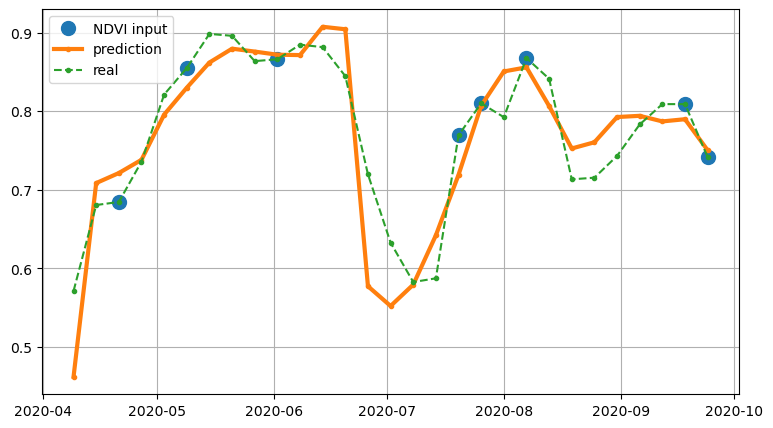

In [11]:
### example case
cc = 106922
print(cc)
yy = y_val[cc].copy()
xx = X_val[cc]

masked_ndvi = xx[:,-1].copy()
masked_ndvi[masked_ndvi==-100] = np.nan

xx_new = []
for j in range(X.shape[2]):
    xx_new.append(xx[:,j].copy().reshape(1,X.shape[1]))
pp = fusion_model.predict(xx_new).reshape(X.shape[1])
plt.figure(figsize=(9,5))
plt.plot(dates,masked_ndvi,marker='.',label='NDVI input',ls='',ms=20)
plt.plot(dates,pp,marker='.',label='prediction',lw=3)
plt.plot(dates,yy,marker='.',ls='--',label='real')
plt.legend()
plt.grid()
plt.show()

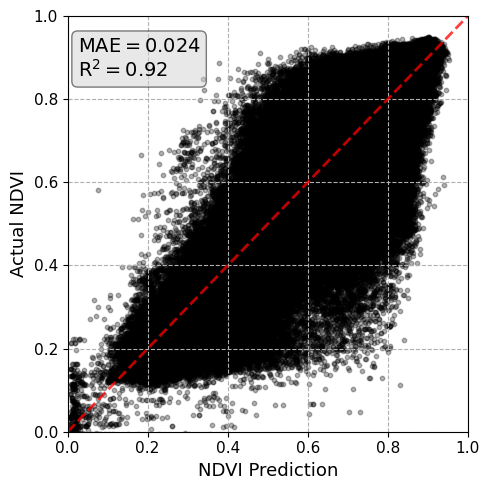

In [12]:
ii = np.where(masks_fused_val.flatten()>0)[0]

pp = preds.flatten()[ii]
yy = y_val.flatten()[ii]

fig,ax = plt.subplots(nrows=1,figsize=(5,5))

ax.scatter(pp,yy,label='',color='black',marker='.',alpha=0.3,s=40)
x_i = y_i = np.linspace(0,1,1000)
ax.plot(x_i,y_i,'r--',lw=2,alpha=0.75)

props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)
textstr = '\n'.join((r'$\mathrm{MAE}=%.3f$' % (round(mean_absolute_error(pp,yy),3)),
                     r'$\mathrm{R^2}=%.2f$' % (round(r2_score(pp,yy),2))))
ax.text(0.025, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_xlabel('NDVI Prediction',fontsize=13)
ax.set_ylabel('Actual NDVI',fontsize=13)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.tick_params(axis='both', which='major', labelsize=11)
ax.grid(linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.show()

In [13]:
# results linear interpolation
results_linear_interp = pd.DataFrame(data=X_val[:,:,-1],columns=dates)
results_linear_interp = results_linear_interp.replace(-100,np.nan).interpolate(method='linear',axis=1).fillna(method='backfill',axis=1).fillna(method='ffill',axis=1).values

In [14]:
# results quadratic interpolation
results_quadratic_interp = pd.DataFrame(data=X_val[:,:,-1],columns=dates)
results_quadratic_interp = results_quadratic_interp.replace(-100,np.nan).interpolate('polynomial',order=2,axis=1).fillna(method='backfill',axis=1).fillna(method='ffill',axis=1).values

In [15]:
# results akima interpolation
results_akima_interp = pd.DataFrame(data=X_val[:,:,-1],columns=dates)
results_akima_interp = results_akima_interp.replace(-100,np.nan).interpolate('akima',axis=1).fillna(method='backfill',axis=1).fillna(method='ffill',axis=1).values

In [17]:
mae = []
mae_linear = []
mae_quadratic = []
mae_akima = []

for i in tqdm(range(len(y_val))):
    try:
        yy = y_val[i].copy()
        pred = preds[i].flatten()
        pred_interp_linear = results_linear_interp[i].flatten()
        pred_interp_quadratic = results_quadratic_interp[i].flatten()
        pred_interp_akima = results_akima_interp[i].flatten()
#         mm = np.where(masks_fused_val[i,:]>0)[0]
#         mm = np.where(masks_fused_val[i,:]==0.25)[0]
        mm = np.where(masks_fused_val[i,:]==0.75)[0]
#         mm = np.array([m for m in mm if m not in [0,len(yy)]])
        mae_linear.append(mean_absolute_error(yy[mm],pred_interp_linear[mm]))
        mae_quadratic.append(mean_absolute_error(yy[mm],pred_interp_quadratic[mm]))
        mae_akima.append(mean_absolute_error(yy[mm],pred_interp_akima[mm]))
        mae.append(mean_absolute_error(yy[mm],pred[mm]))
    except:
        mae.append(np.nan)
        mae_linear.append(np.nan)
        mae_quadratic.append(np.nan)
        mae_akima.append(np.nan)
    
mae = np.array(mae)
mae_linear = np.array(mae_linear)
mae_quadratic = np.array(mae_quadratic)
mae_akima = np.array(mae_akima)

mean=np.nanmean(mae)
median=np.nanmedian(mae)
std=np.nanstd(mae)

mean_linear=np.nanmean(mae_linear)
median_linear=np.nanmedian(mae_linear)
std_linear=np.nanstd(mae_linear)

mean_quadratic=np.nanmean(mae_quadratic)
median_quadratic=np.nanmedian(mae_quadratic)
std_quadratic=np.nanstd(mae_quadratic)

mean_akima=np.nanmean(mae_akima)
median_akima=np.nanmedian(mae_akima)
std_akima=np.nanstd(mae_akima)


100%|█████████████████████████████████████████████████████████████████████████| 365298/365298 [06:09<00:00, 988.67it/s]


In [26]:
print('MEAN ABSOLUTE ERROR (MAE)')
print('--------------------------')
print('CNN-RNN: {:.3f} +/- {:.3f}'.format(mean, std))
print('LINEAR: {:.3f} +/- {:.3f}'.format(mean_linear, std_linear))
print('AKIMA: {:.3f} +/- {:.3f}'.format(mean_akima, std_akima))
print('QUADRATIC: {:.3f} +/- {:.3f}'.format(mean_quadratic, std_quadratic))

MEAN ABSOLUTE ERROR (MAE)
--------------------------
CNN-RNN: 0.036 +/- 0.022
LINEAR: 0.044 +/- 0.025
AKIMA: 0.043 +/- 0.026
QUADRATIC: 0.047 +/- 0.029


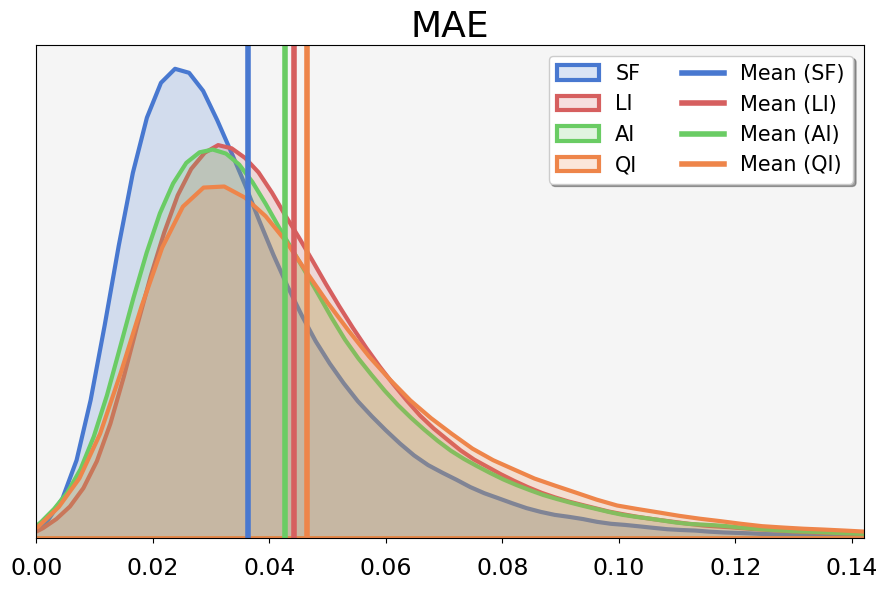

In [18]:
f, ax = plt.subplots(nrows=1,ncols=1,figsize=(9,6),sharex=True)
colors_list = [sns.color_palette('muted')[0],sns.color_palette('muted')[3],
               sns.color_palette('muted')[2],sns.color_palette('muted')[1]]

b0 = sns.kdeplot(mae,ax=ax,color=colors_list[0],alpha=0.2,lw=3,shade=True,label='SF')
b1 = sns.kdeplot(mae_linear,ax=ax,color=colors_list[1],alpha=0.2,lw=3,shade=True,label='LI')
b2 = sns.kdeplot(mae_akima,ax=ax,color=colors_list[2],alpha=0.2,lw=3,shade=True,label='AI')
b3 = sns.kdeplot(mae_quadratic,ax=ax,color=colors_list[3],alpha=0.2,lw=3,shade=True,label='QI')


ax.axvline(mean, color=colors_list[0], linestyle='-',lw=4,label='Mean (SF)')
ax.axvline(mean_linear, color=colors_list[1], linestyle='-',lw=4,label='Mean (LI)')
ax.axvline(mean_akima, color=colors_list[2], linestyle='-',lw=4,label='Mean (AI)')
ax.axvline(mean_quadratic, color=colors_list[3], linestyle='-',lw=4,label='Mean (QI)')

ax.set_facecolor('whitesmoke')
ax.tick_params(axis='x', which='major', labelsize=17, pad=10)
ax.axes.get_yaxis().set_visible(False)
ax.set_ylabel('',fontsize=10)
ax.legend(loc='upper right',shadow=True, ncol=2,fontsize=15)
plt.xlim(0,0.142)
plt.title('MAE',fontsize=26)
plt.tight_layout()
plt.show()